# Import the necessary libraries

In [1]:
import sys
sys.path.append("../../Utils/")

In [59]:
from sklearn.externals import joblib
from sklearn.preprocessing import scale
from scipy.sparse import csr_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, cohen_kappa_score
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, cross_val_predict
import utils
import pandas as pd
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

# Load the data

In [3]:
X_path = '/home/imad/Desktop/Yelp_vectorized_data/Gold/Restaurants_X.pkl'
y_path = '/home/imad/Desktop/Yelp_vectorized_data/Gold/Restaurants_y.pkl'
output_path = './Output/'

In [4]:
# Load a sparse matrix of the text (reviews)
X = joblib.load(X_path)
X.shape

(2827730, 953947)

In [5]:
# Load the labels (ratings)
y = joblib.load(y_path)
y.shape

(2827730,)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Remove 3-star ratings and re-label the training dataset

In [7]:
neutral_ratings_ids = list(np.where(y_train == 3)[0])
len(neutral_ratings_ids)

282296

In [8]:
X_train = utils.delete_from_csr(X_train, row_indices=neutral_ratings_ids)

In [9]:
X_train.shape

(1697115, 953947)

In [10]:
y_train = np.delete(y_train.tolist(), neutral_ratings_ids)

In [11]:
for i in range(0, len(y_train)):
    if y_train[i] == 1 or y_train[i] == 2:
        y_train[i] = -1
    else:
        y_train[i] = 1

In [12]:
y_train.shape

(1697115,)

# Re-label in the test dataset:
## 0,1 -> -1
## 4, 5 -> 1
## 3 -> 0

In [13]:
for i in y_test.index:
    if y_test[i] == 1 or y_test[i] == 2:
        y_test[i] = -1
    elif y_test[i] == 4 or y_test[i] == 5:
        y_test[i] = 1
    else:
        y_test[i] = 0

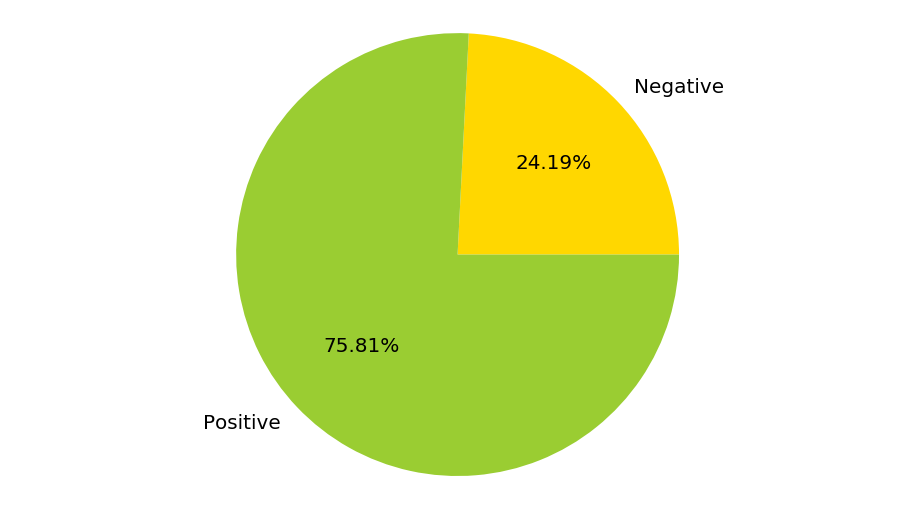

In [14]:
# Rating Distribution
values, counts = np.unique(y_train, return_counts=True)
colors = ['gold', 'yellowgreen']

# Plot
mpl.rcParams['font.size'] = 20.0
f = plt.figure()
f.set_size_inches(16,9)
plt.pie(counts, labels=['Negative', 'Positive'], colors=colors, autopct='%1.2f%%')
plt.axis('equal')
plt.show()
f.savefig(output_path + 'Distribution.pdf')

# Feature Selection

In [15]:
F_scores, P_values = f_classif(X_train, y_train)
print(F_scores)
print(P_values)

/home/imad/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  UserWarning)
/home/imad/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[       nan        nan        nan ... 0.31915871 3.13324002 3.13324002]
[       nan        nan        nan ... 0.57211374 0.07671132 0.07671132]


In [16]:
# Delete high P_values support the null Hypothesis H0
feat_to_delete = []
for i in range(0, len(P_values)):
    if(P_values[i] > 0.05):
        feat_to_delete.append(i)

In [17]:
X_train = utils.delete_from_csr(X_train, col_indices=feat_to_delete)
X_train

<1697115x333128 sparse matrix of type '<type 'numpy.int64'>'
	with 76410178 stored elements in Compressed Sparse Row format>

In [18]:
X_test = utils.delete_from_csr(X_test, col_indices=feat_to_delete)
X_test

<848319x333128 sparse matrix of type '<type 'numpy.int64'>'
	with 39313617 stored elements in Compressed Sparse Row format>

In [19]:
print('Total number of features: {}'.format(len(F_scores)))
print('Number of deleted features: {}'.format(len(feat_to_delete)))
print('Number of remaining features: {}'.format( len(F_scores) - len(feat_to_delete) ))

Total number of features: 953947
Number of deleted features: 620819
Number of remaining features: 333128


# Scaling the data, because SVMs is sensitive to unscaled data

In [20]:
X_train = scale(X_train, with_mean=False)

/home/imad/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [21]:
X_test = scale(X_test, with_mean=False)

# Optimizing SGD paramters

In [22]:
SGD = SGDClassifier(class_weight='balanced', random_state=0)
SGD

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [23]:
params = {'alpha': np.arange(0.00005 , 0.00015, 0.00001)}
grid = GridSearchCV(SGD, params, scoring='f1_weighted')
grid.fit(X_train, y_train)

/home/imad/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([5.0e-05, 6.0e-05, 7.0e-05, 8.0e-05, 9.0e-05, 1.0e-04, 1.1e-04,
       1.2e-04, 1.3e-04, 1.4e-04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [24]:
grid.best_estimator_

SGDClassifier(alpha=9.999999999999999e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_jobs=1, penalty='l2', power_t=0.5, random_state=0,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [25]:
grid.grid_scores_

/home/imad/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.93262, std: 0.00147, params: {'alpha': 5e-05},
 mean: 0.93270, std: 0.00123, params: {'alpha': 6e-05},
 mean: 0.93225, std: 0.00066, params: {'alpha': 7e-05},
 mean: 0.93269, std: 0.00098, params: {'alpha': 7.999999999999999e-05},
 mean: 0.93228, std: 0.00067, params: {'alpha': 8.999999999999999e-05},
 mean: 0.93275, std: 0.00145, params: {'alpha': 9.999999999999999e-05},
 mean: 0.93236, std: 0.00043, params: {'alpha': 0.00010999999999999999},
 mean: 0.93246, std: 0.00091, params: {'alpha': 0.00011999999999999999},
 mean: 0.93252, std: 0.00047, params: {'alpha': 0.00013},
 mean: 0.93260, std: 0.00087, params: {'alpha': 0.00014}]

In [26]:
SGD = grid.best_estimator_

# Cross-validation

In [27]:
SGD_scores = cross_val_score(SGD, X_train, y_train, cv=5, scoring='f1_weighted')
SGD_scores

array([0.9329892 , 0.93446156, 0.93289786, 0.93380569, 0.93565856])

# Save the trained model in a pickle file

In [28]:
joblib.dump(SGD, output_path + 'SGD_r_r_3.pkl')

['./Output/SGD_r_r_3.pkl']

# Apply the model on the test data

In [29]:
SGD_pred = SGD.predict(X_test)
SGD_pred_conf = SGD.decision_function(X_test)
print('Predictions: {}'.format(SGD_pred))
print('Distances to Decision function: {}'.format(SGD_pred_conf))

Predictions: [-1.  1.  1. ...  1.  1.  1.]
Distances to Decision function: [-15.16653897  19.08190284  75.99389208 ...  59.19752311  74.35839897
  97.93119101]


# Re-label the ambiguous predictions as neutral

In [30]:
conf_sr = pd.Series(SGD_pred_conf)
conf_sr.describe()

count    848319.000000
mean         31.079599
std         172.385541
min       -8391.710902
25%         -16.365649
50%          40.885114
75%          88.435675
max        5138.178765
dtype: float64

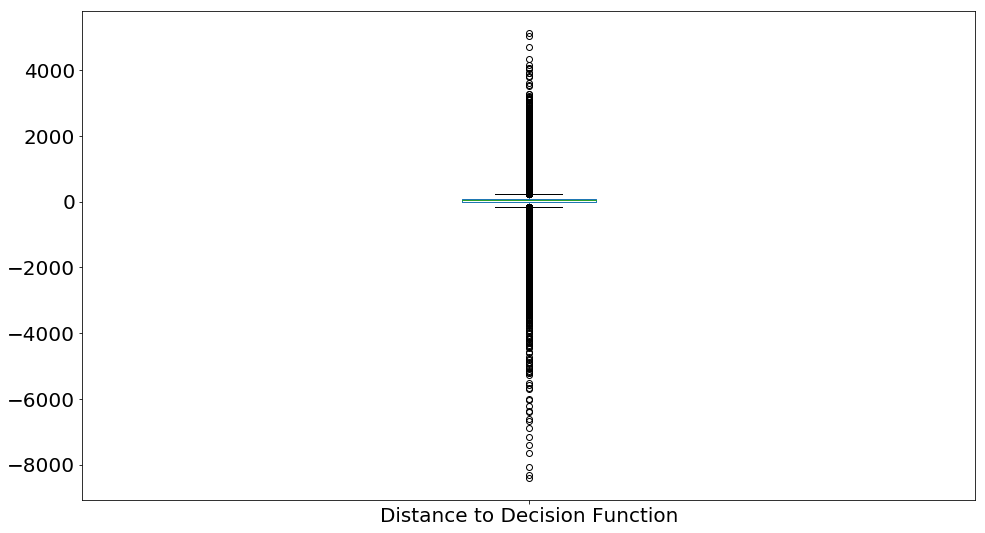

In [31]:
p = conf_sr.plot.box(figsize=(16,9), label='Distance to Decision Function')
p.figure.savefig(output_path + 'Dist_Dec_Func_Box.pdf')

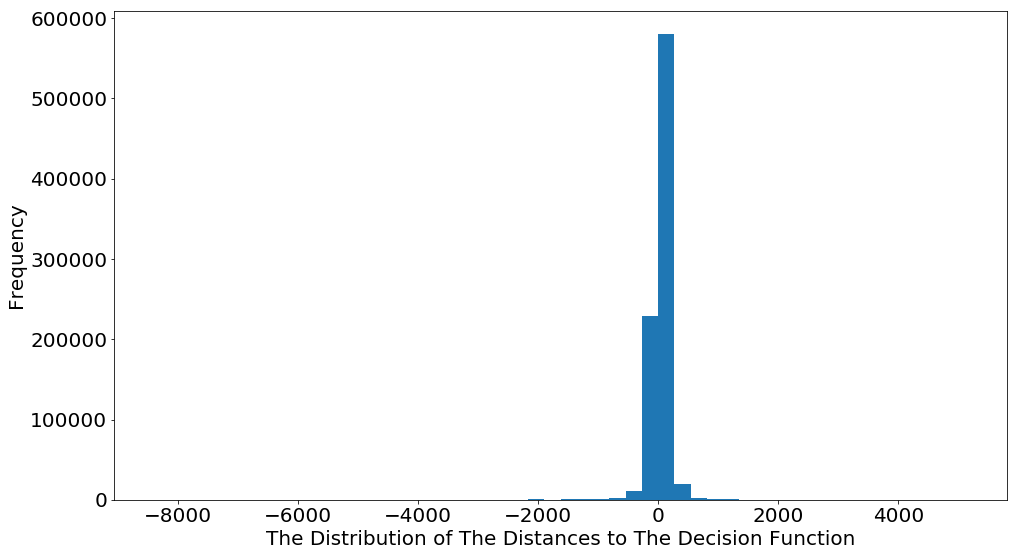

In [32]:
p = conf_sr.plot.hist(bins=50, figsize=(16,9))
p.set_xlabel('The Distribution of The Distances to The Decision Function')
p.figure.savefig(output_path + 'Dist_Dec_Func_Hist.pdf')

In [33]:
ix_ambig = []
for i in range(0, len(y_test)):
    if y_test.values[i] != 0:
        loss = max(0, 1 - y_test.values[i] * SGD_pred_conf[i])
        if loss > 0:
            ix_ambig.append(i)

In [34]:
len(ix_ambig)

50718

In [35]:
for i in ix_ambig:
    SGD_pred[i] = 0

In [36]:
pd.Series(SGD_pred).value_counts()

 1.0    578142
-1.0    219459
 0.0     50718
dtype: int64

In [37]:
joblib.dump(SGD_pred, output_path + 'Predictions.pkl')

['./Output/Predictions.pkl']

# SGD Results

In [38]:
SGD_accuracy = round(accuracy_score(y_test, SGD_pred), 2)
print('Model Accuracy: {}'.format(SGD_accuracy))
with open(output_path + 'Accuracy.txt', 'wb') as f:
    f.write(str(SGD_accuracy))

Model Accuracy: 0.8


In [39]:
SGD_f1 = round(f1_score(y_test, SGD_pred,average='weighted'), 2)
print('Model F1-Score: {}'.format(SGD_f1))
with open(output_path + 'F1.txt', 'wb') as f:
    f.write(str(SGD_f1))

Model F1-Score: 0.76


In [40]:
# Moment of truth, compare the predictions against the labels of the test dataset
SGD_CM = confusion_matrix(y_test, SGD_pred)
print('Confusion Matrix:\n {}'.format(SGD_CM))

Confusion Matrix:
 [[160363  15610      0]
 [ 59096      0  61888]
 [     0  35108 516254]]


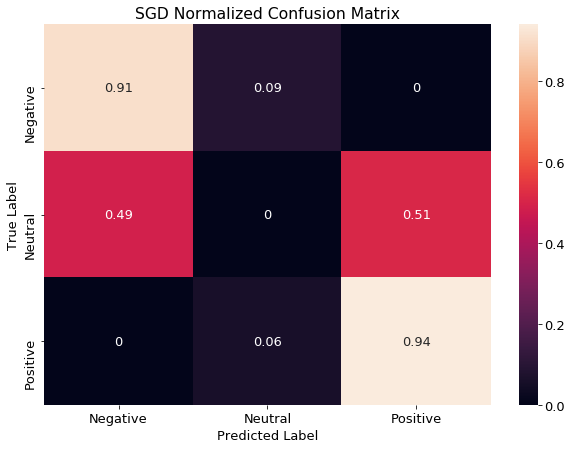

In [41]:
mpl.rcParams['font.size'] = 13.0
utils.cm_plot(SGD_CM, ['Negative', 'Neutral', 'Positive'], 'SGD Normalized Confusion Matrix', output_path + 'SGD_CM.pdf')

In [42]:
print(classification_report(y_test, SGD_pred))

             precision    recall  f1-score   support

       -1.0       0.73      0.91      0.81    175973
        0.0       0.00      0.00      0.00    120984
        1.0       0.89      0.94      0.91    551362

avg / total       0.73      0.80      0.76    848319



# Cohen's-Kappa with Random Classifier

In [54]:
dummy = DummyClassifier(strategy='stratified')

In [56]:
dummy_scores = cross_validate(dummy, X_train, y_train, cv=5, scoring='f1_weighted', return_train_score=False)

In [60]:
dummy_pred = cross_val_predict(dummy, X_test, y_test, cv=5)

In [62]:
pd.Series(dummy_pred).value_counts()

 1.0    551110
-1.0    176563
 0.0    120646
dtype: int64

In [63]:
len(dummy_pred)

848319

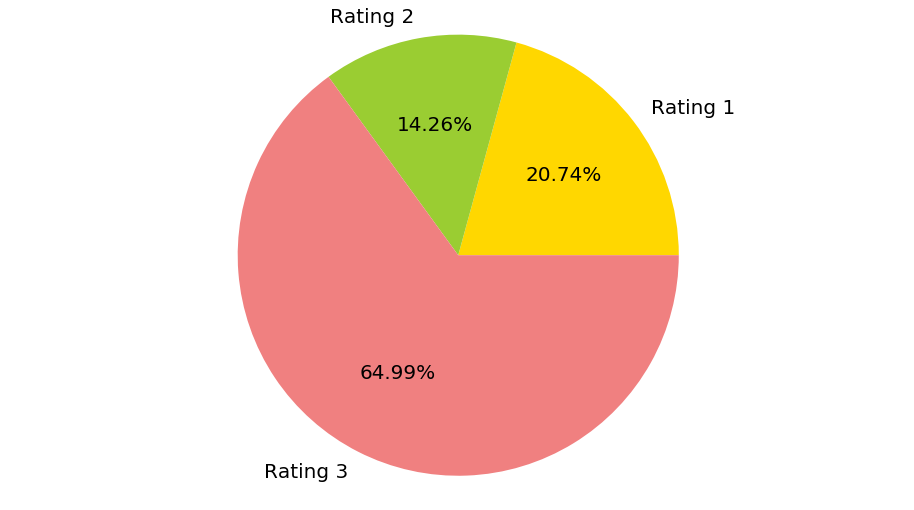

In [69]:
# Rating Distribution
counts = y_test.value_counts()
labels = ['Rating 1', 'Rating 2', 'Rating 3']
sizes = [counts[-1], counts[0], counts[1]]
colors = ['gold', 'yellowgreen', 'lightcoral']

# Plot
mpl.rcParams['font.size'] = 20.0
f = plt.figure()
f.set_size_inches(16,9)
ax = plt.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%')
plt.axis('equal')
plt.show()
f.savefig(output_path + 'Random_Distribution.pdf')

In [70]:
print(cohen_kappa_score(SGD_pred, dummy_pred))

-0.0019180274239207762
